# Get elevation data given lat and lon 

## We will use elevation data from https://www.landfire.gov/version_download.php# 

In [2]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [6]:
#File paths
data_path      = '/Users/hrh/Desktop/AI/erdos/rapower_data/'
data_path2     = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data/'
ca_gridpath   = data_path2 + 'CA_data_version_2.csv'
elevation_datapath = data_path + 'LF2020_Elev_220_CONUS/'

### Read lats and lons for CA into a GeoDataframe

In [38]:
df_main             = pd.read_csv(ca_gridpath)
ca_grid             = df_main.loc[df_main['State']=='CA']
# ca_grid_usable      = ca_grid.loc[ca_grid['land_cover']==1.0]
ca_coords           = list(zip(ca_grid['lat'], ca_grid['lon']))
#Check if ca_coords are within california grid box
ca_lats = [item[0] for item in ca_coords] 
ca_lons = [item[1] for item in ca_coords]
(min(ca_lats),max(ca_lats)),(min(ca_lons),max(ca_lons))

((32.53767702167681, 42.00186839932766),
 (-124.47184652921426, -114.13859171386824))

In [39]:
# Create a GeoDataFrame for California coordinates
geometry = [Point(xy) for xy in ca_coords]
# ca_gdf   = gpd.GeoDataFrame(geometry=geometry)
ca_gdf   = gpd.GeoDataFrame({'geometry': [Point(lon, lat) for lat, lon in ca_coords]
                           }, crs="EPSG:4326")  # Make sure to set the correct coordinate reference system
ca_gdf

,geometry
0,POINT (-124.47185 40.41799)
1,POINT (-124.47185 40.43754)
2,POINT (-124.47185 40.45709)
3,POINT (-124.45027 40.39843)
4,POINT (-124.45027 40.41799)
...,...
102145,POINT (-114.16016 34.27799)
102146,POINT (-114.16016 34.29755)
102147,POINT (-114.16016 34.31710)
102148,POINT (-114.13859 34.25844)


### Read elevation data 

In [40]:
#elevation data path 
elevation_tif_path = elevation_datapath + 'Tif/LC20_Elev_220.tif'
# Open the elevation raster
# Check the CRS of the GeoDataFrame and the Raster
with rasterio.open(elevation_tif_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Raster Bounds: {src.bounds}")

print(f"GeoDataFrame CRS: {ca_gdf.crs}")

Raster CRS: EPSG:5070
Raster Bounds: BoundingBox(left=-2362395.0, bottom=221265.0, right=2327655.0, top=3267405.0)
GeoDataFrame CRS: EPSG:4326


In [41]:
with rasterio.open(elevation_tif_path) as src:
    #Convert the ca_gdf dataframe to the crs of the source
    ca_gdf = ca_gdf.to_crs(src.crs)
    # Mask the raster with the GeoDataFrame to get the elevation values for California coordinates
    # out_image, out_transform = mask(src, [g for g in ca_gdf['geometry'].values], crop=True)
    # ca_elevation_data            = out_image[0]  # Assuming elevation data is in the first band
    # Sample the raster at the given points
    ca_elevation_values = [val[0] for val in src.sample([(geom.x, geom.y) for geom in ca_gdf.geometry])]


In [42]:
len(ca_elevation_values)

102150

In [43]:
# Create a DataFrame from the sampled elevation values
ca_elevation = pd.DataFrame({
    'lat': [geom.y for geom in ca_gdf.geometry],
    'lon': [geom.x for geom in ca_gdf.geometry],
    'elevation': ca_elevation_values
})

In [44]:
ca_elevation

,lat,lon,elevation
0,2.289950e+06,-2.359659e+06,0
1,2.292043e+06,-2.359013e+06,0
2,2.294136e+06,-2.358366e+06,0
3,2.287321e+06,-2.358571e+06,0
4,2.289414e+06,-2.357925e+06,0
...,...,...,...
102145,1.404102e+06,-1.649158e+06,201
102146,1.406249e+06,-1.648743e+06,228
102147,1.408395e+06,-1.648327e+06,148
102148,1.401582e+06,-1.647637e+06,112


###  Convert the DataFrame back to a GeoDataFrame with the original CRS (EPSG:4326)

In [45]:
#CRS transformation after creating a geodata frame
ca_elevation_gdf = gpd.GeoDataFrame(ca_elevation, geometry=gpd.points_from_xy(ca_elevation.lon, ca_elevation.lat),crs='EPSG:5070') # Set to raster's CRS to match the sampling
print('The coordinate reference system of ca_elevation_gdf is:',ca_elevation_gdf.crs)

# Now, reproject to EPSG:4326
ca_elevation_gdf = ca_elevation_gdf.to_crs("EPSG:4326")
print('The coordinate reference system of ca_elevation_gdf is:',ca_elevation_gdf.crs)

# Assuming 'ca_elevation_gdf' has been correctly reprojected to EPSG:4326
ca_elevation_gdf['lat'] = ca_elevation_gdf.geometry.y
ca_elevation_gdf['lon'] = ca_elevation_gdf.geometry.x

The coordinate reference system of ca_elevation_gdf is: EPSG:5070
The coordinate reference system of ca_elevation_gdf is: EPSG:4326


In [46]:
#### Because of re-gridding, some points have no slope data and I have decided to set those slopes to None
no_data_locations = ca_elevation_gdf[ca_elevation_gdf['elevation'] == -9999]
no_data_locations

,lat,lon,elevation,geometry
1889,39.401171,-123.889387,-9999,POINT (-123.88939 39.40117)
2137,39.205630,-123.846242,-9999,POINT (-123.84624 39.20563)
2734,39.029643,-123.759952,-9999,POINT (-123.75995 39.02964)
5044,38.619007,-123.457936,-9999,POINT (-123.45794 38.61901)
12970,37.797734,-122.595034,-9999,POINT (-122.59503 37.79773)
...,...,...,...,...
80735,32.537677,-117.201895,-9999,POINT (-117.20189 32.53768)
80736,32.557231,-117.201895,-9999,POINT (-117.20189 32.55723)
80737,32.576785,-117.201895,-9999,POINT (-117.20189 32.57679)
80738,32.596339,-117.201895,-9999,POINT (-117.20189 32.59634)


In [47]:
# Verify the transformation
ca_elevation_gdf

,lat,lon,elevation,geometry
0,40.417999,-124.471844,0,POINT (-124.47184 40.41800)
1,40.437553,-124.471844,0,POINT (-124.47184 40.43755)
2,40.457107,-124.471843,0,POINT (-124.47184 40.45711)
3,40.398444,-124.450272,0,POINT (-124.45027 40.39844)
4,40.417998,-124.450272,0,POINT (-124.45027 40.41800)
...,...,...,...,...
102145,34.277993,-114.160164,201,POINT (-114.16016 34.27799)
102146,34.297547,-114.160164,228,POINT (-114.16016 34.29755)
102147,34.317101,-114.160164,148,POINT (-114.16016 34.31710)
102148,34.258439,-114.138592,112,POINT (-114.13859 34.25844)


In [48]:
ca_elevation_gdf.loc[ca_elevation_gdf['elevation'] == -9999, 'elevation'] = None

### Finally, load the CA shape file and check if the elevation information makes sense by plotting 

EPSG:4326


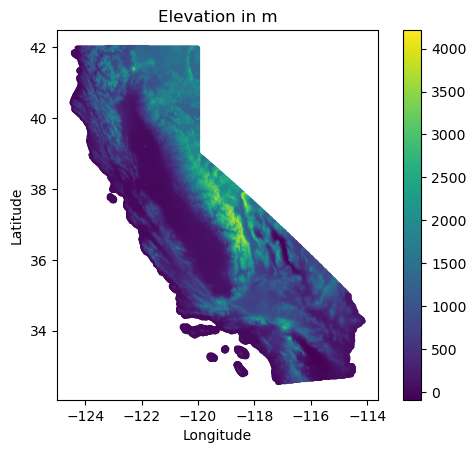

In [49]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)
# Plot the California shapefile as the base
ca_shape.plot(color='white', edgecolor='black')

# Plot the elevation data
ca_elevation_gdf.plot(ax=plt.gca(), column='elevation', legend=True, markersize=5, cmap='viridis')

plt.title('Elevation in m')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Finally, save the dataframe to a csv file after dropping the 'geometry' column

In [50]:
# Save to CSV
ca_elevation_gdf.drop(columns='geometry').to_csv(data_path2+'ca_elevation.csv', index=False)

In [51]:
#Check
ca_elevation_check = pd.read_csv(data_path2+'ca_elevation.csv')
ca_elevation_check

,lat,lon,elevation
0,40.417999,-124.471844,0.0
1,40.437553,-124.471844,0.0
2,40.457107,-124.471843,0.0
3,40.398444,-124.450272,0.0
4,40.417998,-124.450272,0.0
...,...,...,...
102145,34.277993,-114.160164,201.0
102146,34.297547,-114.160164,228.0
102147,34.317101,-114.160164,148.0
102148,34.258439,-114.138592,112.0


### Add elevation data to the big dataframe

In [52]:
ca_features = pd.read_csv(data_path2+'ca_data_version_2.csv')
# ca_features0    = conus_features0.loc[df_main['State']=='CA']
ca_features

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1.0
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.0
102148,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [53]:
# Ensure both GeoDataFrames have the same CRS
# Convert ca_features to a GeoDataFrame
gdf_ca_features = gpd.GeoDataFrame(
    ca_features, 
    geometry=gpd.points_from_xy(ca_features.lon, ca_features.lat),
    crs="EPSG:4326"
)

# Ensure ca_elevation is a GeoDataFrame with the same CRS
gdf_ca_elevation = gpd.GeoDataFrame(
    ca_elevation_check,
    geometry=gpd.points_from_xy(ca_elevation_check.lon, ca_elevation_check.lat),
    crs="EPSG:4326"
)

# Reproject to a suitable projected CRS for accurate distance calculations
gdf_ca_features     = gdf_ca_features.to_crs("EPSG:3310")
gdf_ca_elevation    = gdf_ca_elevation.to_crs("EPSG:3310")


In [54]:
# Perform the spatial join to find the nearest neighbors and get their 'elevation'
ca_features_with_elevation = gpd.sjoin_nearest(gdf_ca_features, gdf_ca_elevation[['geometry', 'elevation']], how='left', distance_col='distance')

# If you don't need the distance information, drop the 'distance' column
ca_features_with_elevation.drop(columns=['index_right', 'distance',], inplace=True)

# Optionally, project back to geographic CRS if needed for other purposes
ca_features_with_elevation = ca_features_with_elevation.to_crs("EPSG:4326")

ca_features_with_elevation

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,geometry,elevation
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,POINT (-124.47184 40.41800),0.0
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,POINT (-124.47184 40.43755),0.0
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,POINT (-124.47184 40.45711),0.0
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,POINT (-124.45027 40.39844),0.0
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,POINT (-124.45027 40.41800),0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,POINT (-114.16016 34.27799),201.0
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1.0,POINT (-114.16016 34.29755),228.0
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.0,POINT (-114.16016 34.31710),148.0
102148,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,POINT (-114.13859 34.25844),112.0


In [55]:
ca_features_with_elevation.loc[ca_features_with_elevation['land_cover']==1.0]['elevation']

34         76.0
58        270.0
59        218.0
60        193.0
61         69.0
          ...  
102143    370.0
102145    201.0
102146    228.0
102147    148.0
102149    117.0
Name: elevation, Length: 66442, dtype: float64

In [56]:
solar_farms = ca_features_with_elevation[ca_features_with_elevation['Solar_farm_present'] == 1]
solar_farms

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,geometry,elevation
13910,38.032383,-122.508744,1.0,CA,0.019112,1.438727,6.0,0.019112,0.0,0.0,"2FJV+G3 San Rafael, CA, USA",0.0,2.0,POINT (-122.50874 38.03238),1.0
16288,40.633080,-122.314591,1.0,CA,0.026765,1.910786,702.0,0.026765,0.0,0.0,"JMJJ+R4 Columbia, Redding, CA, USA",1.0,1.0,POINT (-122.31459 40.63308),185.0
16536,40.496202,-122.293018,1.0,CA,0.014312,1.127613,3.0,0.014312,0.0,0.0,"6759 Airport Rd, Redding, CA 96002, USA",0.0,1.0,POINT (-122.29302 40.49620),149.0
16678,38.267033,-122.271446,1.0,CA,0.034076,NaN,3.0,0.034076,0.0,1.0,"7PCC+W7 Napa, CA, USA",1.0,1.0,POINT (-122.27145 38.26703),9.0
18748,38.227924,-122.098865,1.0,CA,0.032722,2.263317,4.0,0.032722,0.0,0.0,"6WJ4+QW Fairfield, CA, USA",0.0,1.0,POINT (-122.09887 38.22792),10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96540,35.588119,-115.432945,1.0,CA,5.889066,179.797992,6.0,5.889066,0.0,0.0,"HHP8+27 Calada, CA, USA",1.0,1.0,POINT (-115.43295 35.58812),816.0
96753,33.828249,-115.389800,1.0,CA,14.031455,373.646009,6.0,14.031455,0.0,0.0,"RJ96+C8 Desert Center, CA, USA",0.0,1.0,POINT (-115.38980 33.82825),216.0
99819,33.574045,-114.915204,1.0,CA,0.308603,NaN,3.0,0.308603,0.0,1.0,"H38J+CM Blythe, CA, USA",1.0,1.0,POINT (-114.91520 33.57405),131.0
99948,33.574045,-114.893631,1.0,CA,0.033762,NaN,3.0,0.033762,0.0,1.0,"H38W+3C Blythe, CA, USA",0.0,1.0,POINT (-114.89363 33.57405),133.0


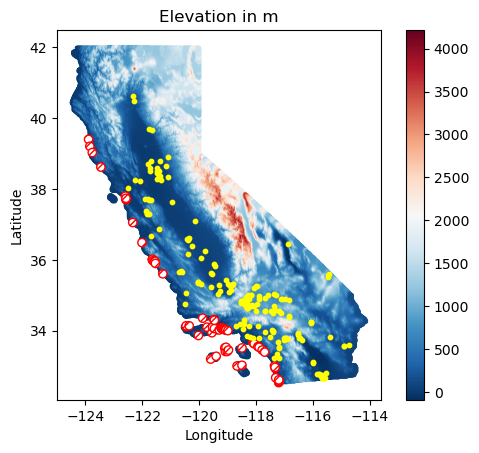

In [57]:
# Plot the California shapefile as the base only locations with solar farms

fig, ax = plt.subplots()
ca_shape.plot(ax=ax,color='white', edgecolor='black')

# Plot the slope data
ca_features_with_elevation.plot(ax=ax, column='elevation', legend=True, markersize=5, cmap='RdBu_r',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })



# Plot these points on top of the existing plot
solar_farms.plot(ax=ax, color='yellow', markersize=10, marker='o', label='solar_farms')

#Title and axis labels
plt.title('Elevation in m')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# Add a legend
# plt.legend()

# Show the plot
plt.show()

### Finally, save this data as a CSV file

In [58]:
ca_features_with_elevation.drop(columns='geometry').to_csv(data_path2+'ca_data_version_3.csv', index=False)

In [59]:
ca_features_with_elevation_check = pd.read_csv(data_path2+'ca_data_version_3.csv')
ca_features_with_elevation_check 

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,201.0
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1.0,228.0
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.0,148.0
102148,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,112.0
